In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

import numpy as np
import tensorflow as tf
# tf.enable_eager_execution()
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow_datasets as tfds

begintime = time.time()

In [2]:
# Define parameters for the model
learning_rate = 0.01
batch_size = 256
n_epochs = 20
n_train = 60000
n_test = 10000



# Step 1: Read in data

In [3]:

def load_fashion_mnist():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # Normalize the data
    x_train = (x_train / 255.0).astype(np.float32)
    x_test = (x_test / 255.0).astype(np.float32)

    # Flatten the images
    x_train = x_train.reshape(-1, 28*28)
    x_test = x_test.reshape(-1, 28*28)

    # One-hot encode the labels
    y_train = tf.one_hot(y_train, 10)
    y_test = tf.one_hot(y_test, 10)

    return (x_train, y_train), (x_test, y_test)

# Load and preprocess data
(x_train, y_train), (x_test, y_test) = load_fashion_mnist()



# Step 2: Create datasets and iterator

In [4]:
# Step 2: Create datasets and iterator
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(10000).batch(batch_size)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size)



## Step 3: Create weights and bias

In [5]:
# Step 3: Create weights and bias
# Initialize weights with Xavier initialization
w = tf.Variable(tf.random.normal([28*28, 10],mean=0.0, stddev=0.01)) #Guassian
b = tf.Variable(tf.zeros([10]))



## Steps 4 - 6

In [6]:
# Step 4: Build model
def logistic_regression(x):
  logits = tf.matmul(x, w) + b
  return logits

# Step 5: Define loss function
def loss_fn(logits, labels):
    return tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    )

# Step 6: Define optimizer (to be used one after the other
# by uncommenting it one after the other and running the notebook (program) all over again )

optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = tf.optimizers.SGD(learning_rate)

# optimizer = tf.optimizers.RMSprop(learning_rate)



# Step 7: Defining accuracy and training steps

In [7]:
# Define accuracy step

# preds = tf.nn.softmax(logistic_regression(x))
# correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(label, 1))
# accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))

def accuracy(preds, labels):
  correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
  return tf.reduce_mean(
        tf.cast(correct_preds,
                tf.float32)
    )

# Define training step
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = tf.nn.softmax(logistic_regression(x))
        loss = loss_fn(preds, y)
    gradients = tape.gradient(loss, [w, b])
    optimizer.apply_gradients(zip(gradients, [w, b]))
    return loss, preds



## Training loop

Epoch 1/20
Loss: 1.6909
Training Accuracy: 0.7886
Test Accuracy: 0.8276
------------------------
Epoch 2/20
Loss: 1.6310
Training Accuracy: 0.8400
Test Accuracy: 0.8290
------------------------
Epoch 3/20
Loss: 1.6189
Training Accuracy: 0.8494
Test Accuracy: 0.8424
------------------------
Epoch 4/20
Loss: 1.6132
Training Accuracy: 0.8539
Test Accuracy: 0.8320
------------------------
Epoch 5/20
Loss: 1.6090
Training Accuracy: 0.8570
Test Accuracy: 0.8421
------------------------
Epoch 6/20
Loss: 1.6057
Training Accuracy: 0.8603
Test Accuracy: 0.8438
------------------------
Epoch 7/20
Loss: 1.6023
Training Accuracy: 0.8633
Test Accuracy: 0.8426
------------------------
Epoch 8/20
Loss: 1.6014
Training Accuracy: 0.8639
Test Accuracy: 0.8380
------------------------
Epoch 9/20
Loss: 1.5987
Training Accuracy: 0.8657
Test Accuracy: 0.8495
------------------------
Epoch 10/20
Loss: 1.5983
Training Accuracy: 0.8666
Test Accuracy: 0.8457
------------------------
Epoch 11/20
Loss: 1.5961
Trai

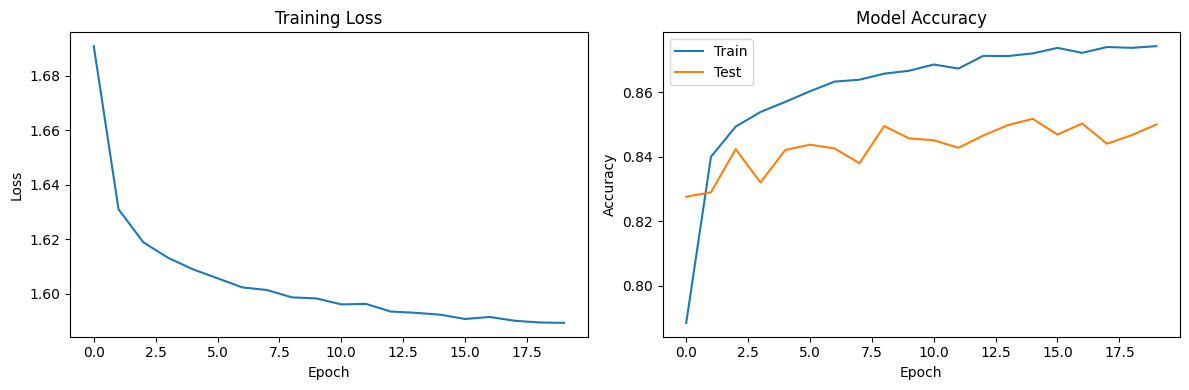

In [8]:
# Training loop
train_losses = []
train_accuracies = []
test_accuracies = []
start_time = time.time()

for epoch in range(n_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    n_batches = 0

    # Training
    for x_batch, y_batch in train_data:
        batch_loss, preds = train_step(x_batch, y_batch)
        batch_accuracy = accuracy(preds, y_batch)

        epoch_loss += batch_loss
        epoch_accuracy += batch_accuracy
        n_batches += 1

    # Calculate average loss and accuracy for the epoch
    epoch_loss = epoch_loss / n_batches
    epoch_accuracy = epoch_accuracy / n_batches
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Testing
    test_accuracy = 0
    n_test_batches = 0
    for x_test_batch, y_test_batch in test_data:
        logits = logistic_regression(x_test_batch)
        test_accuracy += accuracy(logits, y_test_batch)
        n_test_batches += 1
    test_accuracy = test_accuracy / n_test_batches
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{n_epochs}")
    print(f"Loss: {epoch_loss:.4f}")
    print(f"Training Accuracy: {epoch_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print("------------------------")

training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

# Plot training metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [9]:
NAME = 'Damilola'
sum(ord(c) for c in NAME)

803

## Helper Functions
   - plot_images
   - plot_weights

In [10]:
# Helper function to plot images
def plot_images(images, labels, predictions=None):
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                   'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')

        if predictions is None:
            plt.title(class_names[np.argmax(labels[i])])
        else:
            plt.title(f'True: {class_names[np.argmax(labels[i])]}\n'
                     f'Pred: {class_names[np.argmax(predictions[i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot weights
def plot_weights():
    w_min = tf.reduce_min(w)
    w_max = tf.reduce_max(w)

    plt.figure(figsize=(15, 6))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.title(f'Class {i}')
        plt.imshow(w[:, i].numpy().reshape(28, 28),
                  cmap='seismic',
                  vmin=w_min,
                  vmax=w_max)
        plt.axis('off')
    plt.tight_layout()
    plt.show()



Plotting Sample Predictions and learned weights

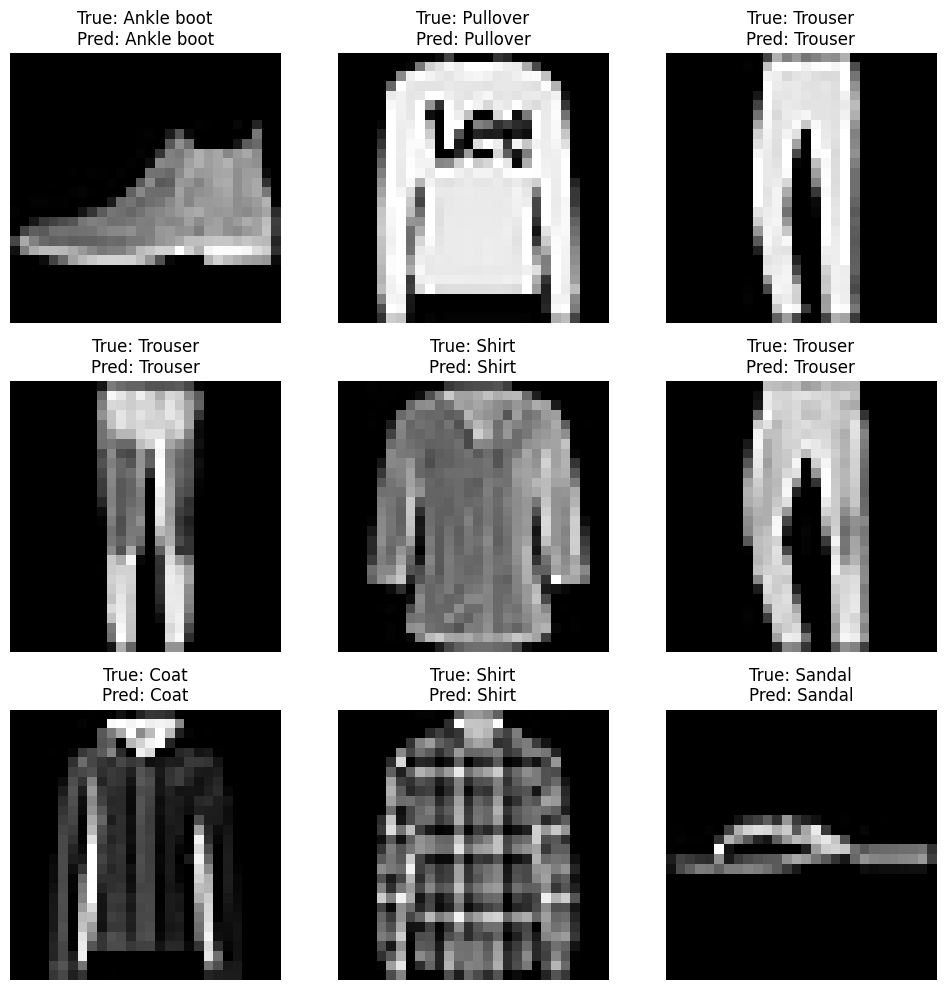

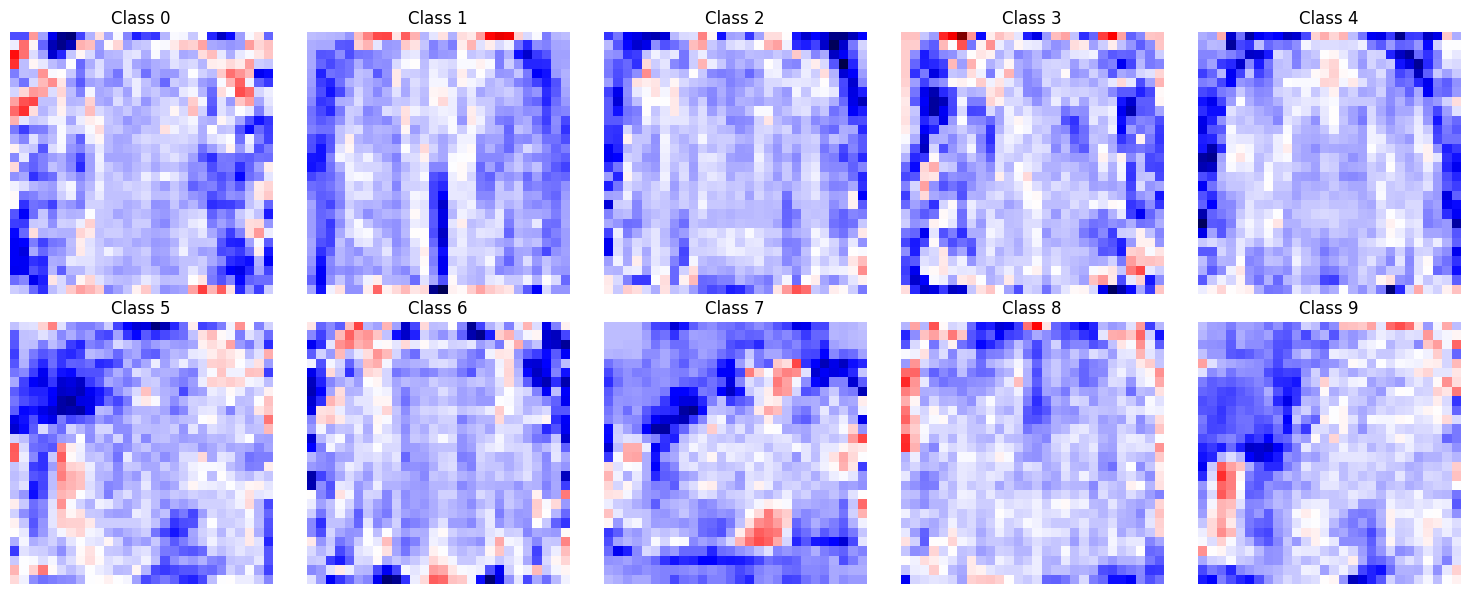

In [11]:
# Plot sample predictions
test_images = x_test[:9]
test_labels = y_test[:9]
predictions = tf.nn.softmax(logistic_regression(test_images))
plot_images(test_images, test_labels, predictions)

# Plot learned weights
plot_weights()